# NBA Last Two Minute Reports

To increase transparency into officiating, the NBA began to publish reports that contain a breakdown of calls in the last two minutes of close games. Beginning on March 1, 2015, these reports detail all calls and notable non-calls in games that had a point differential of three or fewer at any time in the last two minutes. [This site](https://official.nba.com/2019-20-nba-officiating-last-two-minute-reports/) describes the process in more detail along with reports from this season and archived reports.

The goal of this notebook is to explore the reports and use data visualization to further enhance the takeaways from the data available on the website linked above.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools
from datetime import datetime, timedelta

from PIL import Image
import PIL.ImageOps    
import time
from IPython.display import IFrame

from py_ball import image, boxscore, scoreboard

HEADERS = {'Connection': 'keep-alive',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'x-nba-stats-origin': 'stats',
           'x-nba-stats-token': 'true',
           'Accept-Language': 'en-US,en;q=0.9',
           "X-NewRelic-ID": "VQECWF5UChAHUlNTBwgBVw==",
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6)' +\
                         ' AppleWebKit/537.36 (KHTML, like Gecko)' + \
                         ' Chrome/81.0.4044.129 Safari/537.36'}

TEAM_TO_ID_NBA = {'TOR': '1610612761', 'DEN': '1610612743',
                  'DET': '1610612765', 'NOP': '1610612740',
                  'MIL': '1610612749', 'GSW': '1610612744',
                  'SAS': '1610612759', 'POR': '1610612757',
                  'LAC': '1610612746', 'DAL': '1610612742',
                  'MEM': '1610612763', 'PHI': '1610612755',
                  'BOS': '1610612738', 'MIN': '1610612750',
                  'CHA': '1610612766', 'IND': '1610612754',
                  'ORL': '1610612753', 'MIA': '1610612748',
                  'HOU': '1610612745', 'SAC': '1610612758',
                  'UTA': '1610612762', 'BKN': '1610612751',
                  'ATL': '1610612737', 'PHX': '1610612756',
                  'WAS': '1610612764', 'NYK': '1610612752',
                  'OKC': '1610612760', 'LAL': '1610612747',
                  'CLE': '1610612739', 'CHI': '1610612741'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

Let's read in the report data and do some exploration. These data were sourced from the above official's last-two-minute site that contains each qualifying play this season.

In [2]:
l2m_df = pd.read_csv('l2m.csv')
l2m_df.head()

,Period,Time,Call Type,Committing Player,Disadvantaged Player,Review Decision,Video,Comment,game_id
0,Q4,01:53.3,Foul: Offensive,OG Anunoby,Brandon Ingram,CNC,http://official.nba.com/last-two-minute-report...,Anunoby (TOR) firms up in a legal screening po...,21900001
1,Q4,1:44,Foul: Offensive,Serge Ibaka,Nicolo Melli,CNC,http://official.nba.com/last-two-minute-report...,Ibaka (TOR) makes marginal contact with Melli ...,21900001
2,Q4,01:41.4,Foul: Shooting,JJ Redick,Kyle Lowry,CNC,http://official.nba.com/last-two-minute-report...,Redick (NOP) contests Lowry's (TOR) jump shot ...,21900001
3,Q4,01:34.5,Foul: Personal,Fred VanVleet,Brandon Ingram,CNC,http://official.nba.com/last-two-minute-report...,VanVleet (TOR) maintains a legal guarding posi...,21900001
4,Q4,01:09.6,Foul: Personal,Fred VanVleet,Brandon Ingram,INC,http://official.nba.com/last-two-minute-report...,VanVleet (TOR) is late to establish himself in...,21900001


And here's the data from the 2018 regular season after the All Star break.

In [3]:
l2m_2018 = pd.read_csv('l2m_2018.csv')
l2m_2018.head()

,Period,Time,Call Type,Committing Player,Disadvantaged Player,Review Decision,Video,Comment,game_id
0,Q4,01:58.0,Foul: Shooting,JJ Redick,Dwyane Wade,CNC,http://official.nba.com/last-two-minute-report...,Redick (PHI) makes marginal contact to the bod...,21800868
1,Q4,01:45.6,Foul: Personal,Dion Waiters,Jimmy Butler,CNC,http://official.nba.com/last-two-minute-report...,Waiters (MIA) briefly engages with Butler (PHI...,21800868
2,Q4,01:43.0,Turnover: Traveling,Ben Simmons,,CNC,http://official.nba.com/last-two-minute-report...,B. Simmons (PHI) maintains his pivot foot on t...,21800868
3,Q4,01:40.5,Foul: Offensive,Boban Marjanovic,Dion Waiters,CNC,http://official.nba.com/last-two-minute-report...,Marjanovic (PHI) makes marginal contact with W...,21800868
4,Q4,01:36.2,Foul: Shooting,Justise Winslow,Boban Marjanovic,CC,http://official.nba.com/last-two-minute-report...,Winslow (MIA) makes contact to the arm of Marj...,21800868


To bolster the sample, we can combine these datasets.

In [4]:
l2m_df = pd.concat([l2m_2018, l2m_2019], axis=0)

In [3]:
l2m_df

,Period,Time,Call Type,Committing Player,Disadvantaged Player,Review Decision,Video,Comment,game_id
0,Q4,01:53.3,Foul: Offensive,OG Anunoby,Brandon Ingram,CNC,http://official.nba.com/last-two-minute-report...,Anunoby (TOR) firms up in a legal screening po...,21900001
1,Q4,1:44,Foul: Offensive,Serge Ibaka,Nicolo Melli,CNC,http://official.nba.com/last-two-minute-report...,Ibaka (TOR) makes marginal contact with Melli ...,21900001
2,Q4,01:41.4,Foul: Shooting,JJ Redick,Kyle Lowry,CNC,http://official.nba.com/last-two-minute-report...,Redick (NOP) contests Lowry's (TOR) jump shot ...,21900001
3,Q4,01:34.5,Foul: Personal,Fred VanVleet,Brandon Ingram,CNC,http://official.nba.com/last-two-minute-report...,VanVleet (TOR) maintains a legal guarding posi...,21900001
4,Q4,01:09.6,Foul: Personal,Fred VanVleet,Brandon Ingram,INC,http://official.nba.com/last-two-minute-report...,VanVleet (TOR) is late to establish himself in...,21900001
...,...,...,...,...,...,...,...,...,...
7542,Q5,00:06.7,Foul: Loose Ball,Amir Coffey,Devon Hall,CC,http://official.nba.com/last-two-minute-report...,Coffey (LAC) initiates contact across Hall's (...,21901317
7543,Q5,00:06.6,Foul: Loose Ball,Patrick Patterson,Hamidou Diallo,CNC,http://official.nba.com/last-two-minute-report...,Patterson (LAC) makes marginal contact with Di...,21901317
7544,Q5,00:05.3,Turnover: 5 Second Violation,Clippers,Thunder,CNC,http://official.nba.com/last-two-minute-report...,Mann (LAC) inbounds the ball within five seconds.,21901317
7545,Q5,00:05.3,Foul: Offensive,Patrick Patterson,Darius Bazley,CNC,http://official.nba.com/last-two-minute-report...,Patterson (LAC) rests his hand against Bazley'...,21901317


In [4]:
list(set(l2m_df['Call Type']))

[nan,
 'Turnover: 8 Second Violation',
 'Turnover: Lane Violation',
 'Turnover: Out of Bounds',
 'Turnover: 24 Second Violation',
 'Violation: Delay of Game',
 'Foul: Personal',
 'Violation: Defensive Goaltending',
 'Instant Replay: Support Ruling',
 'Foul: Clear Path',
 'Foul: Offensive',
 'Turnover:  Out of Bounds - Bad Pass Turn',
 'Foul: Shooting',
 'Turnover: Double Dribble',
 'Turnover: Stepped out of Bounds',
 'Foul: Loose Ball',
 'Turnover: Palming',
 'Instant Replay: Overturn Ruling',
 'Violation: Lane',
 'Turnover: Inbound Turnover',
 'Foul: Flagrant Type 1',
 'Turnover: Traveling',
 'Turnover: Lost Ball Out of Bounds',
 'Turnover: Foul',
 'Turnover: Bad Pass',
 'Turnover: 5 Second Violation',
 'Foul: Personal Block',
 'Turnover: 3 Second Violation',
 'Foul: Away from Play',
 'Foul: Technical',
 'Foul: Personal Take',
 'Foul: Defense 3 Second',
 'Turnover: Jump Ball Violation',
 'Turnover: Illegal Screen',
 'Foul: Delay Technical',
 'Turnover: Offensive Goaltending',
 'Foul: 

There are many types of calls that get reviewed in these reports, which belong to 5 classes:
- Foul
- Turnover
- Violation
- Instant Replay
- Stoppage

We can store these classes in a feature, `Call Class`.

In [5]:
l2m_df['Call Class'] = ['None' if pd.isnull(x) else
                        'Foul' if 'Foul:' in x else
                        'Turnover' if 'Turnover:' in x else
                        'Violation' if 'Violation:' in x else
                        'Instant Replay' if 'Instant Replay:' in x else
                        'Stoppage' for x in l2m_df['Call Type']]

In [6]:
l2m_df.groupby('Call Class')['Call Class'].count()

Call Class
Foul              6999
Instant Replay      13
None                10
Stoppage            11
Turnover           443
Violation           71
Name: Call Class, dtype: int64

The vast majority of calls reviewed in the Last Two Minute reports involve foul calls or non-calls, followed by turnovers. The rest of the classifications are relatively rare. 

The NBA also abbreviates common plays with the following definitions:
- SQBR - Speed, Quickness, Balance, Rhythm
- POC - Point of Contact
- OOB - Out of Bounds
- FOM - Freedom of Movement

Let's extract these into a `Play Class` feature.

In [7]:
l2m_df['Play Class'] = ['None' if pd.isnull(x) else
                        'SQBR' if 'SQBR' in x else
                        'POC' if 'POC' in x else
                        'OOB' if 'OOB' in x else
                        'FOM' if 'FOM' in x else
                        'Other' for x in l2m_df['Comment']]

In [8]:
l2m_df.groupby('Play Class')['Play Class'].count()

Play Class
FOM       160
None        1
OOB         1
Other    7073
SQBR      312
Name: Play Class, dtype: int64

Even though the NBA defines several common play types, only FOM and SQBR plays make it into the comments. Let's dive deeper on fouls, the most commonly reviewed play class.

## Fouls

In [9]:
foul_df = l2m_df[l2m_df['Call Class']=='Foul']
foul_df.groupby(['Call Type', 'Review Decision'])['Call Type'].count()

Call Type               Review Decision
Foul: Away from Play    CC                   12
                        CNC                  83
                        INC                  12
Foul: Clear Path        CC                    3
Foul: Defense 3 Second  CNC                  57
                        INC                  17
Foul: Delay Technical   CC                    3
Foul: Double Technical  CC                    3
Foul: Flagrant Type 1   CC                    1
Foul: Loose Ball        CC                   68
                        CNC                 642
                        IC                    5
                        INC                  48
Foul: Offensive                               1
                        CC                   51
                        CNC                1621
                        IC                    8
                        INC                  63
Foul: Personal          CC                  768
                        CNC                1546


When a play is indirectly related to the outcome of a posssession or requires technical support, these are not classified as incorrectly officiated. These are indicated in the above breakdown by empty strings. For example, five potential shooting fouls met this criteria in the dataset. The other strings indicate:

- `CC`: Correct call
- `CNC`: Correct non-call
- `IC`: Incorrect call
- `INC`: Incorrect non-call

There are two other strings in the above: `NCC` and `NCI`, which are likely just typos. Let's correct those and view the accuracy rate for called and non-called potential fouls.

In [10]:
foul_df['Review Decision'] = ['CNC' if x == 'NCC'
                              else 'INC' if x == 'NCI'
                              else x for x in foul_df['Review Decision']]

In [11]:
type_df = pd.DataFrame(foul_df.groupby('Review Decision')['Review Decision'].aggregate(['count'])).reset_index()
type_df

,Review Decision,count
0,,1
1,CC,1331
2,CNC,5264
3,IC,53
4,INC,350


In [12]:
call_accuracy = (type_df[type_df['Review Decision']=='CC']['count'].iloc[0] /
    (type_df[type_df['Review Decision']=='CC']['count'].iloc[0] + type_df[type_df['Review Decision']=='IC']['count'].iloc[0]))
call_count = type_df[type_df['Review Decision']=='CC']['count'].iloc[0]
call_sum = type_df[type_df['Review Decision']=='IC']['count'].iloc[0] + call_count

noncall_accuracy = (type_df[type_df['Review Decision']=='CNC']['count'].iloc[0] /
    (type_df[type_df['Review Decision']=='CNC']['count'].iloc[0] + type_df[type_df['Review Decision']=='INC']['count'].iloc[0]))
noncall_count = type_df[type_df['Review Decision']=='CNC']['count'].iloc[0]
noncall_sum = type_df[type_df['Review Decision']=='INC']['count'].iloc[0] + noncall_count

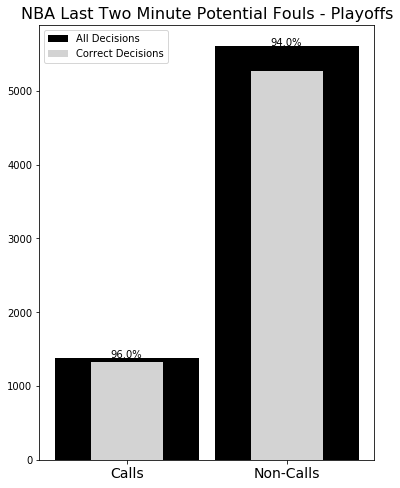

In [13]:
fig = plt.figure(figsize=(6, 8))

axis = fig.add_axes()

bar_width_po = 0.9
bar_width_league = 0.45

# Adjusting the vertical locations of the horizontal bars to match with the axis tick labels
hort_locations = np.arange(2)
#hort_locations = [x + bar_height_po/2 for x in vert_locations]

axis = fig.add_axes()

plt.bar(x=hort_locations,
        height=[call_sum, noncall_sum], width=bar_width_po,
        color='black', label = 'All Decisions')
plt.bar(x=hort_locations,
        height=[call_count, noncall_count], width=bar_width_league,
        color='lightgray', label = 'Correct Decisions')

count = 0
for perc, chal in zip([call_accuracy, noncall_accuracy], [call_sum, noncall_sum]):
    plt.text(count-0.1, chal + 0.1, str(round(perc*100)) + '%')
    count += 1

plt.xticks(range(0, 2),
           ['Calls', 'Non-Calls'],
           rotation=0, fontsize=14)

# plt.yticks(np.arange(0, max([call_sum, noncall_sum]) + 1, step=5))
# for x in np.arange(0, max([call_sum, noncall_sum]) + 1, step=10):
#     plt.axhline(x, linestyle='--', color='gray')
plt.title("NBA Last Two Minute Potential Fouls - Playoffs", fontsize=16)
plt.legend(loc='upper left')
plt.show()

This visualization is hard to believe, but a look into what constitutes a play being reviewed in the Last Two Minute reports is revealing. All whistles are assessed, which would cause the accuracy on calls to skyrocket. Why? As per the NBA:

`There must be clear and conclusive video evidence in order to make a determination that a play was incorrectly officiated`

The NBA is restricting the number of `IC` due to this high burden of proof. Whistles are presumed to be correct and must meet the above criteria to be overturned. Additionally, personal take fouls are considered, which are essentially fouls for which the defense _intentionally fouls_ the opponent. For these reasons, the accuracy of officials on calls is likely inflated.

Furthermore, non-calls also require this burden of proof, but non-calls are only considered for review when "notable" and:

`Notable non-calls will generally be defined as material plays directly related to the outcome of a possession`

First, the NBA has some discretion on which plays are considered here due to the inclusion of the word "generally" in the above. Because of this, the league can include or exclude calls to artificially boost accuracy and the performance on non-notable non-calls cannot be known from these reports. Second, officials are performing _worse_ on non-calls, which are, by definition, more material than the population of calls.

Let's take a look at turnovers

## Turnovers

In [14]:
to_df = l2m_df[l2m_df['Call Class']=='Turnover']
to_df.groupby(['Call Type', 'Review Decision'])['Call Type'].count()

Call Type                                 Review Decision
Turnover:  Out of Bounds - Bad Pass Turn  CC                 46
Turnover: 24 Second Violation             CC                 33
                                          CNC                 2
                                          INC                 2
Turnover: 3 Second Violation              CC                  3
                                          CNC                30
                                          INC                 4
Turnover: 5 Second Inbound                CNC                 3
                                          INC                 1
Turnover: 5 Second Violation              CC                  5
                                          CNC                 9
                                          INC                 9
Turnover: 8 Second Violation              CC                  2
                                          CNC                 6
                                          INC 

In [15]:
type_df = pd.DataFrame(to_df.groupby('Review Decision')['Review Decision'].aggregate(['count'])).reset_index()
type_df

,Review Decision,count
0,CC,162
1,CNC,187
2,IC,10
3,INC,84


Alarmingly, a high number of plays fall into the category that were incorrectly officiated, but cannot be classified as such due to requiring technical support for the decision-making process. Consider the play below and navigate to the URL to view it.

In [16]:
to_df[to_df['Review Decision']==' ']['Comment'].iloc[50]

IndexError: single positional indexer is out-of-bounds

In [17]:
to_df[to_df['Review Decision']==' ']['Video'].iloc[50]

IndexError: single positional indexer is out-of-bounds

This travelling violation does not require enhanced video to be observed. While many of these plays probably require technial support to reach a decision, some do not and this seems like a bit of a safety valve to assign fewer incorrect calls or non-calls.

In [24]:
call_accuracy = (type_df[type_df['Review Decision']=='CC']['count'].iloc[0] /
    (type_df[type_df['Review Decision']=='CC']['count'].iloc[0] + type_df[type_df['Review Decision']=='IC']['count'].iloc[0]))
call_count = type_df[type_df['Review Decision']=='CC']['count'].iloc[0]
call_sum = type_df[type_df['Review Decision']=='IC']['count'].iloc[0] + call_count

noncall_accuracy = (type_df[type_df['Review Decision']=='CNC']['count'].iloc[0] /
    (type_df[type_df['Review Decision']=='CNC']['count'].iloc[0] + type_df[type_df['Review Decision']=='INC']['count'].iloc[0]))
noncall_count = type_df[type_df['Review Decision']=='CNC']['count'].iloc[0]
noncall_sum = type_df[type_df['Review Decision']=='INC']['count'].iloc[0] + noncall_count

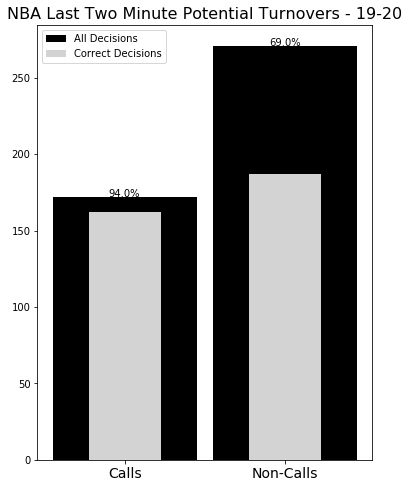

In [25]:
fig = plt.figure(figsize=(6, 8))

axis = fig.add_axes()

bar_width_po = 0.9
bar_width_league = 0.45

# Adjusting the vertical locations of the horizontal bars to match with the axis tick labels
hort_locations = np.arange(2)
#hort_locations = [x + bar_height_po/2 for x in vert_locations]

axis = fig.add_axes()

plt.bar(x=hort_locations,
        height=[call_sum, noncall_sum], width=bar_width_po,
        color='black', label = 'All Decisions')
plt.bar(x=hort_locations,
        height=[call_count, noncall_count], width=bar_width_league,
        color='lightgray', label = 'Correct Decisions')

count = 0
for perc, chal in zip([call_accuracy, noncall_accuracy], [call_sum, noncall_sum]):
    plt.text(count-0.1, chal + 0.1, str(round(perc*100)) + '%')
    count += 1

plt.xticks(range(0, 2),
           ['Calls', 'Non-Calls'],
           rotation=0, fontsize=14)

# plt.yticks(np.arange(0, max([call_sum, noncall_sum]) + 1, step=5))
# for x in np.arange(0, max([call_sum, noncall_sum]) + 1, step=10):
#     plt.axhline(x, linestyle='--', color='gray')
plt.title("NBA Last Two Minute Potential Turnovers - 19-20", fontsize=16)
plt.legend(loc='upper left')
plt.show()

Given the caveats above for these plays and the large number of plays deemed incorrectly officiated through technical support, it is no surprise that the accuracy on non-calls here is very low.


## Exploration

1. Can you think of any other dimensions through which this data can be visualized? Give it a try!
2. Try changing the type of visualization and see if the potential takeaways change.
3. Can you find any other takeaways from the figures besides those presented?